In [1]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras import backend as K
import numpy as np
import params
import random
from keras.optimizers import Adam, RMSprop

import midi_utils
import plot_utils
import models
import params

import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# User constants
dir_name = 'results/history/'
sub_dir_name = 'basic'
num_measures = 16
use_pca = True

C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\tensorflow\

In [2]:
print("Keras version: " + keras.__version__)

K.set_image_data_format('channels_first')

print("Loading encoder...")
# priority name.h5 in sub, model.h5 in sub, name.h5 in dir, model.h5 in dir
if os.path.isfile(dir_name + sub_dir_name + '/' + sub_dir_name + '.h5'):
    model = load_model(dir_name + sub_dir_name + '/' + sub_dir_name + '.h5')

elif os.path.isfile(dir_name + sub_dir_name + '/' + 'model.h5'):
    model = load_model(dir_name + sub_dir_name + '/' + 'model.h5')

elif os.path.isfile(dir_name + sub_dir_name + '.h5'):
    model = load_model(dir_name + sub_dir_name + '.h5')

else:
    model = load_model(dir_name + 'model.h5')


encoder = Model(inputs=model.input,
                    outputs=model.get_layer('encoder').output)
encoderFunc = K.function([model.input, K.learning_phase()], 
                    [model.get_layer('encoder').output])
decoder = K.function([model.get_layer('decoder').input, K.learning_phase()],
                         [model.layers[-1].output])
# decoder = Model(inputs=model.get_layer('decoder').input,
#                     outputs=model.layers[-1].output)

print("Loading gaussian/pca statistics...")
latent_means = np.load(dir_name + sub_dir_name + '/latent_means.npy')
latent_stds = np.load(dir_name + sub_dir_name + '/latent_stds.npy')
latent_pca_values = np.load(
    dir_name + sub_dir_name + '/latent_pca_values.npy')
latent_pca_vectors = np.load(
    dir_name + sub_dir_name + '/latent_pca_vectors.npy')

W0608 23:25:06.865839 31156 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0608 23:25:06.904905 31156 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Keras version: 2.2.4
Loading encoder...


W0608 23:25:07.065491 31156 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\keras\backend\tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0608 23:25:07.066457 31156 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0608 23:25:07.201126 31156 deprecation.py:506] From C:\ProgramData\Anaconda2\envs\tensor3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0608 23:25:07.821541 31156 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda2\en

Loading gaussian/pca statistics...


In [10]:
# model.summary()
encoder.summary()

encoder.compile(optimizer=RMSprop(lr=0.01), loss='binary_crossentropy')
# decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 96, 96)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 9216)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 2000)          18434000  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 200)           400200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1600)              5121600   
_________________________________________________________________
dense_4 (Dense)              (None, 40)                64040     
__________

In [11]:
np.random.seed(42)
random.seed(42)

# network params
DROPOUT_RATE = 0.1
BATCHNORM_MOMENTUM = 0.9  # weighted normalization with the past
USE_EMBEDDING = False
USE_VAE = False
VAE_B1 = 0.02
VAE_B2 = 0.1

BATCH_SIZE = 350
MAX_WINDOWS = 16  # the maximal number of measures a song can have
LATENT_SPACE_SIZE = params.num_params
NUM_OFFSETS = 16 if USE_EMBEDDING else 1

K.set_image_data_format('channels_first')

samples_path='data/interim/samples.npy'
lengths_path='data/interim/lengths.npy'

print("Loading Data...")
if not os.path.exists(samples_path) or not os.path.exists(lengths_path):
    print('No input data found, run preprocess_songs.py first.')
    assert(False)

y_samples = np.load(samples_path)
y_lengths = np.load(lengths_path)

samples_qty = y_samples.shape[0]
songs_qty = y_lengths.shape[0]

print("Loaded " + str(samples_qty) + " samples from " + str(songs_qty) + " songs.")
print(np.sum(y_lengths))
assert (np.sum(y_lengths) == samples_qty)

print("Preparing song samples, padding songs...")
x_shape = (songs_qty * NUM_OFFSETS, 1)  # for embedding
x_orig = np.expand_dims(np.arange(x_shape[0]), axis=-1)

y_shape = (songs_qty * NUM_OFFSETS, MAX_WINDOWS) + y_samples.shape[1:]  # (songs_qty, max number of windows, window pitch qty, window beats per measure)
y_orig = np.zeros(y_shape, dtype=np.float32)  # prepare dataset array

# fill in measure of songs into input windows for network
song_start_ix = 0
song_end_ix = y_lengths[0]
for song_ix in range(songs_qty):
    for offset in range(NUM_OFFSETS):
        ix = song_ix * NUM_OFFSETS + offset  # calculate the index of the song with its offset
        song_end_ix = song_start_ix + y_lengths[song_ix]  # get song end ix
        for window_ix in range(MAX_WINDOWS):  # get a maximum number of measures from a song
            song_measure_ix = (window_ix + offset) % y_lengths[song_ix]  # chosen measure of song to be placed in window (modulo song length)
            y_orig[ix, window_ix] = y_samples[song_start_ix + song_measure_ix]  # move measure into window
    song_start_ix = song_end_ix  # new song start index is previous song end index
assert (song_end_ix == samples_qty)
x_train = np.copy(x_orig)
y_train = np.copy(y_orig)

test_ix = 0
y_test_song = np.copy(y_train[test_ix: test_ix + 1])
x_test_song = np.copy(x_train[test_ix: test_ix + 1])
print("saving sample")
midi_utils.samples_to_midi(y_test_song[0], 'data/interim/gt.mid')

Loading Data...
Loaded 8980 samples from 172 songs.
8980
Preparing song samples, padding songs...
saving sample


In [5]:
print(y_train.shape)

(172, 16, 96, 96)


In [12]:
offset = 0
epochs_qty = 1

for epoch in range(epochs_qty):
    if USE_EMBEDDING:
        history = 0
#         history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1)
    else:
        # produce songs from its samples with a different starting point of the song each time
        song_start_ix = 0
        for song_ix in range(songs_qty):
            song_end_ix = song_start_ix + y_lengths[song_ix]
            for window_ix in range(MAX_WINDOWS):
                song_measure_ix = (window_ix + offset) % y_lengths[song_ix]
                y_train[song_ix, window_ix] = y_samples[song_start_ix + song_measure_ix]
                #if params.encode_volume:
                    #y_train[song_ix, window_ix] /= 100.0
            song_start_ix = song_end_ix
        assert (song_end_ix == samples_qty)
        offset += 1
        print(y_train.shape)

#         history = model.fit(y_train, y_train, batch_size=BATCH_SIZE, epochs=1)  # train model on reconstruction loss

(172, 16, 96, 96)


In [13]:
def flattenWindow(song):
    flat = np.zeros((96 * 2, 96 * 8))
    for i in range(2):
        for j in range(8):
            wix = j + i * 8
            flat[i*96:i*96+96, j*96:j*96+96] = song[0][wix]
    return flat

(1, 16, 96, 96)
(192, 768)


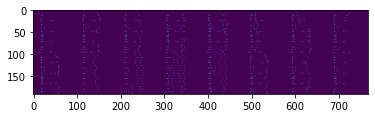

In [14]:
song_ix = 0
song = y_train[song_ix:song_ix+1]
print(song.shape)
flat = flattenWindow(song)
print(flat.shape)

# plt.figure()
# matplotlib.rcParams['figure.figsize'] = [20, 20]
# for i in range(16):
#     plt.subplot(2, 8, i+1)
#     plt.imshow(song[0][i])
# plt.show()

plt.figure()
plt.imshow(flat)
plt.show()

In [21]:
song = tf.convert_to_tensor(song)
print(song)

with tf.GradientTape() as tape:
    tape.watch(song)
    
    latent_x = encoder(song)
    
    print(latent_x)

    if use_pca:
        current_params = np.dot(
            latent_x - latent_means, latent_pca_vectors.T) / latent_pca_values
    else:
        current_params = (
            latent_x - latent_means) / latent_stds

#     print(current_params)
    
gradient = tape.gradient(latent_x, song)
print(gradient)

Tensor("Const_1:0", shape=(1, 16, 96, 96), dtype=float32)
Tensor("model_1/encoder/cond/Merge:0", shape=(?, 40), dtype=float32)
None
